In [1]:
import json
import os
import pickle
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from skimage.transform import resize
from collections import defaultdict, Counter
from math import log
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from itertools import chain
from pprint import pprint
import re

import keras.utils
from keras.applications import Xception
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input, Activation, Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from keras.layers import (concatenate)
from keras.models import Model, load_model, Sequential
from keras.optimizers import Adam

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, cohen_kappa_score, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
%matplotlib inline

data_dir = "C:\\Users\\MariLiis\\PycharmProjects\\PetFinderNN\\data"

sentiment_train_dir =  os.path.join(data_dir, "train_sentiment") 
sentiment_test_dir =  os.path.join(data_dir, "test_sentiment") 

train_image = os.path.join(data_dir, "train_images")
test_image = os.path.join(data_dir, "test_images")

TARGET = "AdoptionSpeed"
TARGET_VALS = range(5)

BATCH_SIZE, test_size = 512, 0.2

height, width = 100, 100

Using TensorFlow backend.


# Feature engineering

## 1. Numerical data into bins

In [2]:
train = pd.read_csv(os.path.join(data_dir, "train.csv"), sep=',')
pet_ids = train["PetID"]

In [3]:
def bin_column(data, col, bins, labels, replace=True):
    binned_data = pd.cut(data[col], bins=bins, labels=labels)
    if replace:
        data[col] = binned_data
    else:
        data['binned_' + col] = binned_data
    return data

In [4]:
train = bin_column(train, 'Age', bins=[-1, 4, 10, 18, 36, 72, 255], labels=range(1, 7), replace=True)
train.Age.value_counts().sum() == len(train)

True

In [5]:
train = bin_column(train, 'Quantity', bins=[0, 1, 2, 3, 6, 10, 20], labels=range(1, 7), replace=True)
train.Quantity.value_counts().sum() == len(train)

True

In [6]:
train = bin_column(train, 'Fee', bins=[-1, 2, 10, 25, 50, 100, 300, 500, 800, 1000, 2000, 3000], labels=range(1, 12), 
                   replace=True)
train.Fee.value_counts().sum() == len(train)

True

In [7]:
train = bin_column(train, 'VideoAmt', bins=[-1, 0, 8], labels=range(0, 2), replace=True)
train.VideoAmt.value_counts().sum() == len(train)

True

In [8]:
train = bin_column(train, 'PhotoAmt', bins=[-1, 0, 3, 10, 30], labels=range(0, 4), replace=True)
train.PhotoAmt.value_counts().sum() == len(train)

True

## 2. Mean Encoding

In [9]:
def mean_encoding(data, col, test_data=None, separate_by_type=False):
    val_counts = data[col].value_counts()
    col_values = val_counts.index
    
    for tgt_val in TARGET_VALS:
        new_col_values = defaultdict(dict)
        for col_val in col_values:
            if not separate_by_type:
                col_val_count = val_counts.loc[col_val]
                col_tgt_count = len(data[(data[col] == col_val) & (data[TARGET] == tgt_val)])
                new_col_values[col_val] = round(col_tgt_count / col_val_count, 2)
            else:
                col_val_count_type1 = len(data[(data[col] == col_val) & (data['Type'] == 1)])
                col_val_count_type2 = len(data[(data[col] == col_val) & (data['Type'] == 2)])
                col_tgt_count_type1 = len(data[(data[col] == col_val) & (data['Type'] == 1) & (data[TARGET] == tgt_val)])
                col_tgt_count_type2 = len(data[(data[col] == col_val) & (data['Type'] == 1) & (data[TARGET] == tgt_val)])
                if col_val_count_type1 > 0:
                    new_col_values[1][col_val] = round(col_tgt_count_type1 / col_val_count_type1, 2)
                if col_val_count_type2 > 0:
                    new_col_values[2][col_val] = round(col_tgt_count_type2 / col_val_count_type2, 2)

        new_col = col + "_" + TARGET + "_" + str(tgt_val)
        
        if not separate_by_type:
            if test_data is None:
                data[new_col] = data[col]
                data[new_col].replace(new_col_values, inplace=True)
            else:
                test_data[new_col] = test_data[col]
                test_data[new_col].replace(new_col_values, inplace=True)
        else:
            if test_data is None:
                copy = data[col]
                for col_val in new_col_values:
                    idx_1 = data[(data[col] == col_val) & (data['Type'] == 1)].index
                    copy.iloc[idx_1].replace(new_col_values[1], inplace=True)
                    idx_2 = data[(data[col] == col_val) & (data['Type'] == 2)].index
                    copy.iloc[idx_2].replace(new_col_values[2], inplace=True)
                data[new_col] = copy
            else:
                copy = test_data[col]
                for col_val in new_col_values:
                    idx_1 = test_data[(test_data[col] == col_val) & (test_data['Type'] == 1)].index
                    copy.iloc[idx_1].replace(new_col_values[1], inplace=True)
                    idx_2 = test_data[(test_data[col] == col_val) & (test_data['Type'] == 2)].index
                    copy.iloc[idx_2].replace(new_col_values[2], inplace=True)
                test_data[new_col] = copy

    return data if test_data is None else test_data

### 1. MaturitySize

In [10]:
train.MaturitySize.value_counts()

2    10305
1     3395
3     1260
4       33
Name: MaturitySize, dtype: int64

In [11]:
train = mean_encoding(train, 'MaturitySize', separate_by_type=True)

In [12]:
train.columns

Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed',
       'MaturitySize_AdoptionSpeed_0', 'MaturitySize_AdoptionSpeed_1',
       'MaturitySize_AdoptionSpeed_2', 'MaturitySize_AdoptionSpeed_3',
       'MaturitySize_AdoptionSpeed_4'],
      dtype='object')

In [13]:
train[['MaturitySize', 'AdoptionSpeed', 'MaturitySize_AdoptionSpeed_0', 'MaturitySize_AdoptionSpeed_1',
       'MaturitySize_AdoptionSpeed_2', 'MaturitySize_AdoptionSpeed_3', 'MaturitySize_AdoptionSpeed_4']].head()

,MaturitySize,AdoptionSpeed,MaturitySize_AdoptionSpeed_0,MaturitySize_AdoptionSpeed_1,MaturitySize_AdoptionSpeed_2,MaturitySize_AdoptionSpeed_3,MaturitySize_AdoptionSpeed_4
0,1,2,1,1,1,1,1
1,2,0,2,2,2,2,2
2,2,3,2,2,2,2,2
3,2,2,2,2,2,2,2
4,2,2,2,2,2,2,2


### 2. FurLength

In [14]:
train.FurLength.value_counts()

1    8808
2    5361
3     824
Name: FurLength, dtype: int64

In [15]:
train = mean_encoding(train, 'FurLength')

In [16]:
train.columns

Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed',
       'MaturitySize_AdoptionSpeed_0', 'MaturitySize_AdoptionSpeed_1',
       'MaturitySize_AdoptionSpeed_2', 'MaturitySize_AdoptionSpeed_3',
       'MaturitySize_AdoptionSpeed_4', 'FurLength_AdoptionSpeed_0',
       'FurLength_AdoptionSpeed_1', 'FurLength_AdoptionSpeed_2',
       'FurLength_AdoptionSpeed_3', 'FurLength_AdoptionSpeed_4'],
      dtype='object')

In [17]:
train[['FurLength', 'FurLength_AdoptionSpeed_0', 'FurLength_AdoptionSpeed_1', 'FurLength_AdoptionSpeed_2', 
       'FurLength_AdoptionSpeed_3', 'FurLength_AdoptionSpeed_4']].head()

,FurLength,FurLength_AdoptionSpeed_0,FurLength_AdoptionSpeed_1,FurLength_AdoptionSpeed_2,FurLength_AdoptionSpeed_3,FurLength_AdoptionSpeed_4
0,1,0.02,0.19,0.27,0.23,0.30
1,2,0.03,0.22,0.27,0.21,0.27
2,2,0.03,0.22,0.27,0.21,0.27
3,1,0.02,0.19,0.27,0.23,0.30
4,1,0.02,0.19,0.27,0.23,0.30


### 3. Gender

In [18]:
train.Gender.value_counts()

2    7277
1    5536
3    2180
Name: Gender, dtype: int64

In [19]:
train = mean_encoding(train, 'Gender')

In [20]:
train.columns

Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed',
       'MaturitySize_AdoptionSpeed_0', 'MaturitySize_AdoptionSpeed_1',
       'MaturitySize_AdoptionSpeed_2', 'MaturitySize_AdoptionSpeed_3',
       'MaturitySize_AdoptionSpeed_4', 'FurLength_AdoptionSpeed_0',
       'FurLength_AdoptionSpeed_1', 'FurLength_AdoptionSpeed_2',
       'FurLength_AdoptionSpeed_3', 'FurLength_AdoptionSpeed_4',
       'Gender_AdoptionSpeed_0', 'Gender_AdoptionSpeed_1',
       'Gender_AdoptionSpeed_2', 'Gender_AdoptionSpeed_3',
       'Gender_AdoptionSpeed_4'],
      dtype='object')

In [21]:
train[['Gender', 'Gender_AdoptionSpeed_0', 'Gender_AdoptionSpeed_1', 'Gender_AdoptionSpeed_2', 'Gender_AdoptionSpeed_3', 
       'Gender_AdoptionSpeed_4']].head()

,Gender,Gender_AdoptionSpeed_0,Gender_AdoptionSpeed_1,Gender_AdoptionSpeed_2,Gender_AdoptionSpeed_3,Gender_AdoptionSpeed_4
0,1,0.03,0.23,0.29,0.20,0.25
1,1,0.03,0.23,0.29,0.20,0.25
2,1,0.03,0.23,0.29,0.20,0.25
3,2,0.03,0.19,0.26,0.23,0.29
4,1,0.03,0.23,0.29,0.20,0.25


### 4. Colors

In [22]:
train = mean_encoding(train, 'Color1')

In [23]:
train = mean_encoding(train, 'Color2')

In [24]:
train = mean_encoding(train, 'Color3')

## 3. Count Encoding

In [25]:
def count_encoding(data, col, replace=True):
    val_counts = data[col].value_counts()
    col_values = list(reversed(val_counts.index))
    if replace:
        data[col] = data[col].apply(lambda x: col_values.index(x))
    else:
        data[col + "Counts"] = data[col].apply(lambda x: col_values.index(x))
    return data

In [26]:
train = count_encoding(train, 'RescuerID', False)

In [27]:
train.columns

Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed',
       'MaturitySize_AdoptionSpeed_0', 'MaturitySize_AdoptionSpeed_1',
       'MaturitySize_AdoptionSpeed_2', 'MaturitySize_AdoptionSpeed_3',
       'MaturitySize_AdoptionSpeed_4', 'FurLength_AdoptionSpeed_0',
       'FurLength_AdoptionSpeed_1', 'FurLength_AdoptionSpeed_2',
       'FurLength_AdoptionSpeed_3', 'FurLength_AdoptionSpeed_4',
       'Gender_AdoptionSpeed_0', 'Gender_AdoptionSpeed_1',
       'Gender_AdoptionSpeed_2', 'Gender_AdoptionSpeed_3',
       'Gender_AdoptionSpeed_4', 'Color1_AdoptionSpeed_0',
       'Color1_AdoptionSpeed_1', 'Color1_AdoptionSpeed_2',
       'Color1_AdoptionSpeed_3', 'Color1_AdoptionSpeed_4',
       'Color2_AdoptionSpeed_0', 'Color2_AdoptionSpeed_1',
       'Co

In [28]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(train.RescuerIDCounts.value_counts().sort_index())

0         1
1         1
2         1
3         1
4         1
5         1
6         1
7         1
8         1
9         1
10        1
11        1
12        1
13        1
14        1
15        1
16        1
17        1
18        1
19        1
20        1
21        1
22        1
23        1
24        1
25        1
26        1
27        1
28        1
29        1
30        1
31        1
32        1
33        1
34        1
35        1
36        1
37        1
38        1
39        1
40        1
41        1
42        1
43        1
44        1
45        1
46        1
47        1
48        1
49        1
50        1
51        1
52        1
53        1
54        1
55        1
56        1
57        1
58        1
59        1
60        1
61        1
62        1
63        1
64        1
65        1
66        1
67        1
68        1
69        1
70        1
71        1
72        1
73        1
74        1
75        1
76        1
77        1
78        1
79        1
80        1
81        1
82        1
83  

In [29]:
# bins by count: 0-10, 11-30, 31-60, 61-95, 96+
train = bin_column(train, 'RescuerIDCounts', bins=[-1, 5418, 5545, 5579, 5587, 5594], labels=range(1, 6), replace=True)
train.RescuerIDCounts.value_counts()

1    9261
2    2095
5    1634
3    1378
4     625
Name: RescuerIDCounts, dtype: int64

## 4. Other new features

### 1. Number of colors

In [30]:
train['NrOfColors'] = (train.Color1 > 0).replace(True, 1).replace(False, 0) \
                    + (train.Color2 > 0).replace(True, 1).replace(False, 0) \
                    + (train.Color3 > 0).replace(True, 1).replace(False, 0)

In [31]:
train.NrOfColors.value_counts()

2.0    6133
1.0    4471
3.0    4389
Name: NrOfColors, dtype: int64

### 2. Number of breeds

In [32]:
train['NrOfBreeds'] = (train.Breed1 > 0).replace(True, 1).replace(False, 0) \
                    + (train.Breed2 > 0).replace(True, 1).replace(False, 0)

In [33]:
train.NrOfBreeds.value_counts()

1.0    10767
2.0     4226
Name: NrOfBreeds, dtype: int64

### 3. Is popular state?

In [34]:
train['State'].value_counts(normalize=True).head()

41326    0.581205
41401    0.256453
41327    0.056226
41336    0.033816
41330    0.028013
Name: State, dtype: float64

In [35]:
train['IsPopularState'] = train['State'].isin([41326, 41401]).replace(True, 1).replace(False, 0)

In [36]:
train.IsPopularState.value_counts()

1.0    12559
0.0     2434
Name: IsPopularState, dtype: int64

In [37]:
train['IsPopularState'] = train['IsPopularState'].astype('bool')

## 5. One-hot-encoding

In [38]:
train.columns

Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed',
       'MaturitySize_AdoptionSpeed_0', 'MaturitySize_AdoptionSpeed_1',
       'MaturitySize_AdoptionSpeed_2', 'MaturitySize_AdoptionSpeed_3',
       'MaturitySize_AdoptionSpeed_4', 'FurLength_AdoptionSpeed_0',
       'FurLength_AdoptionSpeed_1', 'FurLength_AdoptionSpeed_2',
       'FurLength_AdoptionSpeed_3', 'FurLength_AdoptionSpeed_4',
       'Gender_AdoptionSpeed_0', 'Gender_AdoptionSpeed_1',
       'Gender_AdoptionSpeed_2', 'Gender_AdoptionSpeed_3',
       'Gender_AdoptionSpeed_4', 'Color1_AdoptionSpeed_0',
       'Color1_AdoptionSpeed_1', 'Color1_AdoptionSpeed_2',
       'Color1_AdoptionSpeed_3', 'Color1_AdoptionSpeed_4',
       'Color2_AdoptionSpeed_0', 'Color2_AdoptionSpeed_1',
       'Co

In [39]:
one_hot_columns = ["Type",
                   "Gender",
                   "Color1",
                   "Color2",
                   "Color3",
                   "MaturitySize",
                   "FurLength",
                   "Vaccinated",
                   "Dewormed",
                   "Sterilized",
                   "Health"]

one_hot_train = pd.get_dummies(train[one_hot_columns], columns=one_hot_columns)

# Collecting Data

In [45]:
NR_COLORS = "NrOfColors"
NR_BREEDS = "NrOfBreeds"
POPULAR_STATE = "IsPopularState"

def make_data(train, test, meanenc_cols=[], countenc_cols=[], bin_cols={}, ohe_cols=[], 
              extra_cols=[NR_COLORS, NR_BREEDS, POPULAR_STATE], separate_meanenc_by_type=False):
    
    if NR_COLORS in extra_cols:
        train[NR_COLORS] = (train.Color1 > 0).replace(True, 1).replace(False, 0) \
                         + (train.Color2 > 0).replace(True, 1).replace(False, 0) \
                         + (train.Color3 > 0).replace(True, 1).replace(False, 0)
        
        test[NR_COLORS] = (test.Color1 > 0).replace(True, 1).replace(False, 0) \
                        + (test.Color2 > 0).replace(True, 1).replace(False, 0) \
                        + (test.Color3 > 0).replace(True, 1).replace(False, 0)
    
    if NR_BREEDS in extra_cols:
        train[NR_BREEDS] = (train.Breed1 > 0).replace(True, 1).replace(False, 0) \
                         + (train.Breed2 > 0).replace(True, 1).replace(False, 0)
        
        test[NR_BREEDS] = (test.Breed1 > 0).replace(True, 1).replace(False, 0) \
                        + (test.Breed2 > 0).replace(True, 1).replace(False, 0)
    
    if POPULAR_STATE in extra_cols:
        train[POPULAR_STATE] = train['State'].isin([41326, 41401]).replace(True, 1).replace(False, 0)        
        train[POPULAR_STATE] = train[POPULAR_STATE].astype('bool')
        
        test[POPULAR_STATE] = test['State'].isin([41326, 41401]).replace(True, 1).replace(False, 0)        
        test[POPULAR_STATE] = test[POPULAR_STATE].astype('bool')
    
    for col, bins in bin_cols.items():
        labels = range(1, len(bins))
        train = bin_column(train, col, bins=bins, labels=labels, replace=False)
        test = bin_column(test, col, bins=bins, labels=labels, replace=False)
        
    for col in meanenc_cols:
        train = mean_encoding(train, col, separate_by_type=separate_meanenc_by_type)        
        test = mean_encoding(train, col, test_data=test, separate_by_type=separate_meanenc_by_type)
    
    for col in countenc_cols:
        train = count_encoding(train, col, False) 
        test = count_encoding(test, col, False) 
        
    if ohe_cols != []:
        one_hot_train = pd.get_dummies(train[ohe_cols], columns=ohe_cols)   
        train = pd.concat([train, one_hot_train], axis=1)
        one_hot_test = pd.get_dummies(test[ohe_cols], columns=ohe_cols)   
        test = pd.concat([test, one_hot_test], axis=1)
    
    y_train = train[TARGET]
        
    return train, test

In [46]:
def read_images(image_paths):
    def random_image():
        return np.random.rand(height, width, 3) * 255
    
    def read_image(path):
        img = np.asarray(Image.open(path).convert("RGB"), dtype="int32" )
        return resize(img, (height, width), anti_aliasing=True, mode='constant')    

    return np.array([read_image(path) if os.path.isfile(path) else random_image() for path in tqdm(image_paths)])

def read_sentiment(pet_ids, sentiment_paths):
    magnitudes, scores = [], []
    
    for pet_id in tqdm(pet_ids):
        file_loc = os.path.join(sentiment_paths, "{}.json".format(pet_id))
        # check if there exists sentiment analysis for the pet, else set scores 0.0
        if os.path.isfile(file_loc):
            with open(file_loc, encoding="UTF-8", mode="r") as json_file:  
                data = json.load(json_file)
                magnitude,score = data["documentSentiment"]["magnitude"], data["documentSentiment"]["score"]
        else:
            magnitude, score = 0.0, 0.0
    
        magnitudes.append(magnitude)
        scores.append(score)
    return magnitudes, scores

In [47]:
meanenc_cols = [
    "MaturitySize",
    "FurLength",
    "Gender"
]
countenc_cols = [
#     'RescuerID'
]
bin_cols = {'Age': [-1, 4, 10, 18, 36, 72, 255], 'Quantity': [0, 1, 2, 3, 6, 10, 20], 
            'Fee': [-1, 2, 10, 25, 50, 100, 300, 500, 800, 1000, 2000, 3000], 'VideoAmt': [-1, 0, 8], 
            'PhotoAmt': [-1, 0, 3, 10, 30]}
ohe_cols = ["Type",
           "Gender",
           "Color1",
           "Color2",
           "Color3",
           "MaturitySize",
           "FurLength",
           "Vaccinated",
           "Dewormed",
           "Sterilized",
           "Health"]

In [43]:
train = pd.read_csv(os.path.join(data_dir, "train.csv"), sep=',')
train_pet_ids = train["PetID"]
test = pd.read_csv(os.path.join(data_dir, "test.csv"), sep=',')
test_ped_ids = test["PetID"]

In [ ]:
magnitudes_train, scores_train = read_sentiment(train_pet_ids, sentiment_train_dir)

In [ ]:
magnitudes_test, scores_test = read_sentiment(test_pet_ids, sentiment_test_dir)

In [48]:
train, test = make_data(train, test, meanenc_cols=meanenc_cols,
                        countenc_cols=countenc_cols, bin_cols=bin_cols, ohe_cols=ohe_cols, 
                        extra_cols=[NR_COLORS, NR_BREEDS, POPULAR_STATE], separate_meanenc_by_type=True)

In [49]:
list(train.columns)

['Type',
 'Name',
 'Age',
 'Breed1',
 'Breed2',
 'Gender',
 'Color1',
 'Color2',
 'Color3',
 'MaturitySize',
 'FurLength',
 'Vaccinated',
 'Dewormed',
 'Sterilized',
 'Health',
 'Quantity',
 'Fee',
 'State',
 'RescuerID',
 'VideoAmt',
 'Description',
 'PetID',
 'PhotoAmt',
 'AdoptionSpeed',
 'NrOfColors',
 'NrOfBreeds',
 'IsPopularState',
 'binned_Age',
 'binned_Quantity',
 'binned_Fee',
 'binned_VideoAmt',
 'binned_PhotoAmt',
 'MaturitySize_AdoptionSpeed_0',
 'MaturitySize_AdoptionSpeed_1',
 'MaturitySize_AdoptionSpeed_2',
 'MaturitySize_AdoptionSpeed_3',
 'MaturitySize_AdoptionSpeed_4',
 'FurLength_AdoptionSpeed_0',
 'FurLength_AdoptionSpeed_1',
 'FurLength_AdoptionSpeed_2',
 'FurLength_AdoptionSpeed_3',
 'FurLength_AdoptionSpeed_4',
 'Gender_AdoptionSpeed_0',
 'Gender_AdoptionSpeed_1',
 'Gender_AdoptionSpeed_2',
 'Gender_AdoptionSpeed_3',
 'Gender_AdoptionSpeed_4',
 'Type_1',
 'Type_2',
 'Gender_1',
 'Gender_2',
 'Gender_3',
 'Color1_1',
 'Color1_2',
 'Color1_3',
 'Color1_4',
 'Colo

In [50]:
def exclude_from_list(lst, excl):
    excl_idx = []
    for e in excl:
        excl_idx.append(lst.index(e))
        
    return np.delete(lst, excl_idx)

In [51]:
selected_cols = exclude_from_list(list(train.columns), [
 'Type',
 'Name',
 'Age',
 'Breed1',
 'Breed2',
 'Gender',
 'Color1',
 'Color2',
 'Color3',
 'MaturitySize',
 'FurLength',
 'Vaccinated',
 'Dewormed',
 'Sterilized',
 'Health',
 'Quantity',
 'Fee',
 'State',
 'RescuerID',
 'VideoAmt',
 'Description',
 'PetID',
 'PhotoAmt',
 'AdoptionSpeed',
])

In [58]:
X_train = train[selected_cols]
y_train = train[TARGET]
X_test = test[selected_cols]
train_pet_ids = train['PetID']
test_pet_ids = test['PetID']

In [53]:
f_im_name = "images.binary"

if not os.path.isfile(f_im_name):
    images = read_images([os.path.join(train_image, pet_id + "-1.jpg") for pet_id in pet_ids])
    
    # Standardize:
    mean, std = np.mean(images), np.std(images)
    images_meanstd = (images - mean)/std
    
    with open(f_im_name, 'wb') as handle_1, open("mnstd", 'wb') as handle_2:
        pickle.dump(images_meanstd, handle_1, protocol=pickle.HIGHEST_PROTOCOL)        
        pickle.dump((mean, std), handle_2, protocol=pickle.HIGHEST_PROTOCOL)

else:
    with open(f_im_name, 'rb') as handle_1, open("mnstd", 'rb') as handle_2:
        images_meanstd = pickle.load(handle_1)
        temp = pickle.load(handle_2)
        mean, std = temp[0], temp[1]
                
print(images_meanstd.shape)

(14993, 100, 100, 3)


In [68]:
X_train_img, X_test_img, X_train_else, X_test_else, y_train, y_test = train_test_split(images_meanstd, 
                                                                                       X_train, 
                                                                                       y_train, 
                                                                                       test_size=test_size,
                                                                                       random_state=1)

# Test Models

### Baseline model

In [70]:
rf = RandomForestClassifier(n_estimators=65, max_depth=15)
rf.fit(X_train_else, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=65, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [71]:
train_pred = [pred for pred in rf.predict(X_train_else)]
test_predictions = [pred for pred in rf.predict(X_test_else)]

print("Kappa on train: {}".format(round(cohen_kappa_score(y_train, train_pred, weights="quadratic"), 4)))
print("Accuracy on train: {}".format(round(accuracy_score(y_train, train_pred), 4)))
print("________________")
print("Kappa on test: {}".format(round(cohen_kappa_score(y_test, test_predictions, weights="quadratic"), 4)))
print("Accuracy on test: {}".format(round(accuracy_score(y_test, test_predictions), 4)))

Kappa on train: 0.7509
Accuracy on train: 0.7881
________________
Kappa on test: 0.2672
Accuracy on test: 0.3685


In [72]:
test_pred_label_rf = rf.predict(X_test)
pd.DataFrame({'PetID': test_pet_ids, 'AdoptionSpeed': test_pred_label_rf}).to_csv('neural_fe_5_rf.csv', index=False)

### Neural net

In [73]:
# https://stackoverflow.com/questions/49618986/neural-network-in-keras-with-two-different-input-types-images-and-values
# https://www.learnopencv.com/keras-tutorial-transfer-learning-using-pre-trained-models/

transfer = Xception(weights='imagenet', include_top=False, input_shape=(height, width, 3))

# Freeze Xception
for layer in transfer.layers[:-3]:
    layer.trainable = False

# Inputs
image_input = Input(shape=(height, width, 3))
aux_input = Input(shape=(len(list(X_train_else)),))

# Images:
transfer = transfer(image_input)
flatten = Flatten()(transfer)

# Aux input:
x = Dense(250, activation='relu')(aux_input)
x = Dense(350, activation='relu')(x)
x = Dense(450, activation='relu')(x)
x = Dense(700, activation='relu')(x)

# Merged:
merge = concatenate([flatten, x])
x = Dense(100, activation='relu')(merge)
h = Dense(5, activation='relu')(x)

# Predictions:
predictions = Activation('softmax')(h)

model = Model(inputs=[image_input, aux_input], outputs=predictions)
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


history = model.fit([X_train_img, X_train_else], 
                    keras.utils.to_categorical(y_train),
                    batch_size=BATCH_SIZE, 
                    epochs=4, 
                    validation_split=0.1,
                    callbacks=[ModelCheckpoint('test_model.h5', save_best_only=True), 
                               EarlyStopping(monitor='val_loss', mode='min', verbose=1)])

Instructions for updating:
Use tf.cast instead.
Train on 10794 samples, validate on 1200 samples
Epoch 1/4
10794/10794 [==============================] - ETA: 36:08 - loss: 1.6025 - acc: 0.27 - ETA: 26:12 - loss: 1.6837 - acc: 0.27 - ETA: 21:50 - loss: 1.6769 - acc: 0.27 - ETA: 21:05 - loss: 1.6891 - acc: 0.27 - ETA: 18:59 - loss: 1.6941 - acc: 0.26 - ETA: 17:14 - loss: 1.6815 - acc: 0.27 - ETA: 15:57 - loss: 1.6930 - acc: 0.27 - ETA: 14:26 - loss: 1.6876 - acc: 0.27 - ETA: 13:08 - loss: 1.6761 - acc: 0.27 - ETA: 12:08 - loss: 1.6722 - acc: 0.27 - ETA: 11:04 - loss: 1.6649 - acc: 0.28 - ETA: 10:02 - loss: 1.6553 - acc: 0.28 - ETA: 8:55 - loss: 1.6572 - acc: 0.2910 - ETA: 7:44 - loss: 1.6495 - acc: 0.296 - ETA: 6:40 - loss: 1.6472 - acc: 0.298 - ETA: 5:39 - loss: 1.6427 - acc: 0.301 - ETA: 4:31 - loss: 1.6429 - acc: 0.303 - ETA: 3:23 - loss: 1.6441 - acc: 0.303 - ETA: 2:17 - loss: 1.6406 - acc: 0.305 - ETA: 1:11 - loss: 1.6415 - acc: 0.308 - ETA: 5s - loss: 1.6393 - acc: 0.3102  - 1602s

Text(0.5, 1.0, 'Accuracy')

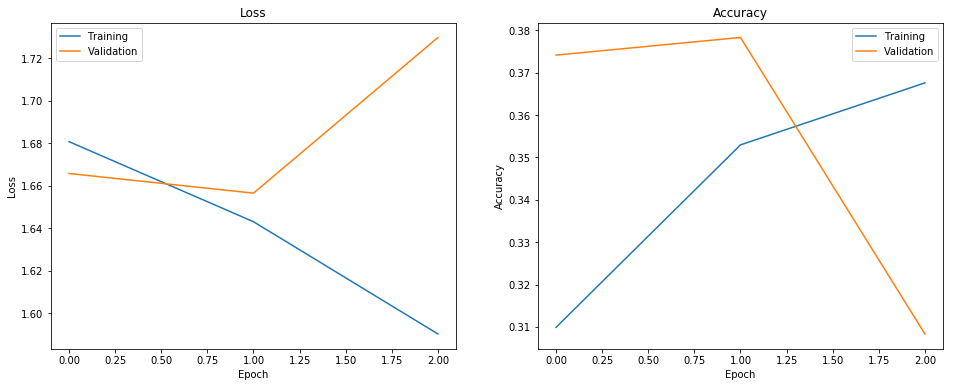

In [74]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.title('Accuracy')

In [75]:
train_pred = [np.argmax(pred) for pred in model.predict([X_train_img, X_train_else])]
test_predictions = [np.argmax(pred) for pred in model.predict([X_test_img, X_test_else])]

In [76]:
print("Kappa on train: {}".format(round(cohen_kappa_score(y_train, train_pred, weights="quadratic"), 4)))
print("Accuracy on train: {}".format(round(accuracy_score(y_train, train_pred), 4)))
print("________________")
print("Kappa on test: {}".format(round(cohen_kappa_score(y_test, test_predictions, weights="quadratic"), 4)))
print("Accuracy on test: {}".format(round(accuracy_score(y_test, test_predictions), 4)))

Kappa on train: 0.1949
Accuracy on train: 0.3144
________________
Kappa on test: 0.2019
Accuracy on test: 0.3028


# Kaggle test

In [78]:
test_images = read_images([os.path.join(test_image, pet_id + "-1.jpg") for pet_id in test_pet_ids])
test_images_std = (test_images - mean)/std

100%|██████████████████████████████████████| 3972/3972 [05:06<00:00, 12.97it/s]


In [79]:
loaded = load_model('test_model.h5')
test_pred = loaded.predict([test_images_std, X_test])
test_pred_label = [np.argmax(pred) for pred in test_pred]
pd.DataFrame({'PetID': test_pet_ids, 'AdoptionSpeed': test_pred_label}).to_csv('neural_fe_5.csv', index=False)